In [34]:
import gensim
from gensim.models import KeyedVectors
from stellargraph.data import EdgeSplitter
import networkx as nx
from sklearn.linear_model import LogisticRegressionCV
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [5]:
train_df = pd.read_csv('../../../../lm-vol/LANL_train_unique_v2.csv')

In [6]:
train_df

,source user@domain,destination computer,source computer
0,ANONYMOUS LOGON@C1697,C1697,C1697
1,ANONYMOUS LOGON@C586,C586,C1505
2,ANONYMOUS LOGON@C586,C586,C586
3,C10081$@DOM1,C528,C528
4,C101$@DOM1,C988,C988
...,...,...,...
1431275,U8500@DOM1,C529,C1128
1431276,U8500@DOM1,C457,C1128
1431277,U8500@DOM1,C1114,C1115
1431278,U8500@DOM1,C1115,C1115


In [7]:
test_df = pd.read_csv('../../../../lm-vol/LANL_test_unique_v2.csv')

In [8]:
test_df

,source user@domain,destination computer,source computer
0,ANONYMOUS LOGON@C586,C586,C1250
1,ANONYMOUS LOGON@C586,C586,C586
2,C101$@DOM1,C988,C988
3,C1020$@DOM1,C1020,C1020
4,C1021$@DOM1,C625,C1021
...,...,...,...
1062869,U7319@?,C528,C528
1062870,U1345@DOM1,C1640,C23653
1062871,U5462@DOM1,C1065,C17256
1062872,U5462@DOM1,C1065,C1065


In [9]:
model = gensim.models.Word2Vec.load('../../../../lm-vol/2_28_new_structure_500_epochs_word2vec.model')
wv = KeyedVectors.load('../../../../lm-vol/2_28_new_structure_500_epochs_word2vec.wordvectors', mmap='r')
G = nx.read_graphml('../../../../lm-vol/LANL_train_unique_v2.graphml')

def operator_hadamard(u, v):
    return u * v

In [10]:
with open('../../../../lm-vol/2_28_new_structure_lr.pkl', 'rb') as file:
    clf = pickle.load(file)

In [11]:
graph_structure = ('source user@domain', 'source computer', 'destination computer')
client_to_ip_pred = []
ip_to_service_pred = []
inconclusive = 0
for index, row in test_df.iterrows():
    try:
        client_embedding = wv[(row[graph_structure[0]])]
        ip_embedding = wv[(row[graph_structure[1]])]
        service_embedding = wv[(row[graph_structure[2]])]
        client_to_ip_embedding = [operator_hadamard(client_embedding, ip_embedding)]
        ip_to_service_embedding = [operator_hadamard(ip_embedding, service_embedding)]
        client_to_ip = clf.predict_proba(client_to_ip_embedding)
        ip_to_service = clf.predict_proba(ip_to_service_embedding)
        client_to_ip_pred.append(client_to_ip[0][1])
        ip_to_service_pred.append(ip_to_service[0][1])
    except: 
        client_to_ip_pred.append(None)
        ip_to_service_pred.append(None)
        inconclusive += 1

In [12]:
len(client_to_ip_pred)

1062874

In [12]:
test_df['client_to_ip'] = client_to_ip_pred
test_df['ip_to_service'] = ip_to_service_pred

In [13]:
anomalous_edges = len(test_df[(test_df["ip_to_service"].astype(float) <= 0.1) | (test_df["client_to_ip"].astype(float) <= 0.1)])
normal_edges = len(test_df[(test_df["ip_to_service"].astype(float) > 0.1) & (test_df["client_to_ip"].astype(float) > 0.1)])
print(anomalous_edges/(normal_edges+anomalous_edges))
print(anomalous_edges)
print(normal_edges)

0.3626282239611694
378928
666021


In [17]:
anomaly_df = test_df[(test_df['ip_to_service'].astype(float) <= 0.1) | (test_df["client_to_ip"].astype(float) <= 0.1)]
anomaly_df

,source user@domain,destination computer,source computer,client_to_ip,ip_to_service
1,ANONYMOUS LOGON@C586,C586,C586,5.206858e-07,0.999836
4,C1021$@DOM1,C625,C1021,9.917411e-01,0.003309
8,C1085$@DOM1,C612,C1085,9.972451e-01,0.082046
13,C119$@DOM1,C528,C119,6.754536e-01,0.027928
14,C1218$@DOM1,C529,C1218,1.323942e-01,0.005345
...,...,...,...,...,...
1062858,U86@DOM1,C586,C24956,9.687175e-01,0.064397
1062861,C21535$@DOM1,C625,C21535,9.710429e-01,0.018474
1062867,U8525@DOM1,C585,C5269,9.989924e-01,0.002329
1062868,U8525@DOM1,C585,C585,2.513690e-02,1.000000


In [30]:
for index, row in anomaly_df.iterrows():
    involved = (row['source user@domain'], row['source computer'], row['destination computer'])
    # get 10 most similiar sources
    similar_sources, similar_source_score = zip(*wv.most_similar(positive=[row['source user@domain']]))
    # get 10 most similar ips
    similar_ips, similar_ip_score = zip(*wv.most_similar(positive=[row['source computer']]))
    # get 10 most similar services
    similar_service, similar_service_score = zip(*wv.most_similar(positive=[row['destination computer']]))
    nodes = list(set(involved + similar_sources + similar_ips + similar_service))
    break

['ANONYMOUS LOGON@C528', 'C528', 'ANONYMOUS LOGON@C586', 'C612', 'ANONYMOUS LOGON@C457', 'ANONYMOUS LOGON@C467', 'C1025', 'ANONYMOUS LOGON@C529', 'C586', 'C467', 'C706', 'U1718@?', 'ANONYMOUS LOGON@C1065', 'C529', 'ANONYMOUS LOGON@C2106', 'TGT', 'C457', 'C1640', 'C1065', 'C2106', 'C625', 'ANONYMOUS LOGON@C612']


In [32]:
anomalies = []
for index, row in anomaly_df.iterrows():
    anomaly = [row['source user@domain'], row['source computer'], row['destination computer']]
    anomalies.append(anomaly)

In [41]:
def explain_graph(anomaly, train_graph):
    
    def filter_node(node):
        return node in filtered_nodes
    
    client_node, ip_node, service_node = anomaly
    involved = (client_node, ip_node, service_node)
    # get 10 most similiar sources
    similar_sources, similar_source_score = zip(*wv.most_similar(positive=[client_node])[:3])
    # get 10 most similar ips
    similar_ips, similar_ip_score = zip(*wv.most_similar(positive=[ip_node])[:3])
    # get 10 most similar services
    similar_service, similar_service_score = zip(*wv.most_similar(positive=[service_node])[:3])
    filtered_nodes = list(set(involved + similar_sources + similar_ips + similar_service))
    view = nx.subgraph_view(train_graph, filter_node = filter_node)
    ColorScale = plt.get_cmap('RdYlGn')
    subgraph = nx.Graph(view)
    subgraph.add_edge(client_node, ip_node)
    subgraph.add_edge(ip_node, service_node)
    for edge in subgraph.edges:
        src, dest = edge
        edge_embedding = [operator_hadamard(model.wv[src],model.wv[dest])]
        edge_prob = clf.predict_proba(edge_embedding)
        subgraph[src][dest]['prob'] = ColorScale(edge_prob[0][1])
    node_colors = []
    for node in subgraph.nodes:
        if node == client_node:
            node_colors.append('yellow')
        elif node == ip_node:
            node_colors.append('orange')
        elif node == service_node:
            node_colors.append('red')
        else:
            node_colors.append('#1f77b4')
    edge_colors = [x[2] for x in subgraph.edges.data('prob')]
    nx.draw(subgraph, edge_color=edge_colors, node_color=node_colors, with_labels=True)

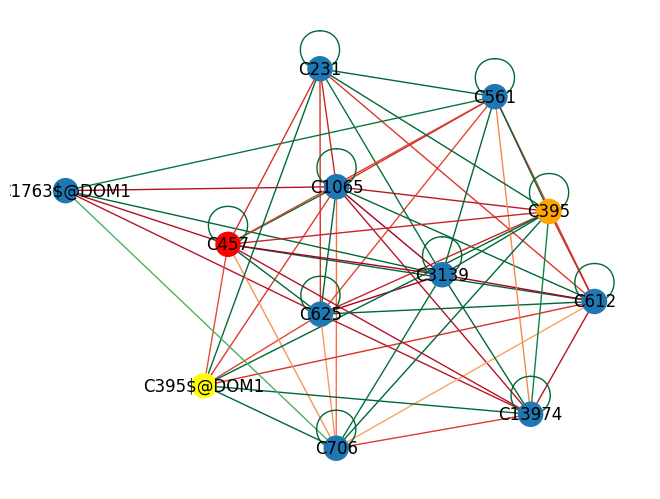

In [42]:
explain_graph(anomalies[75], G)